In [54]:
import os
os.chdir('C:\\Users\\rober\\PycharmProjects\\crusher\\src')
from utils.db.database_manager import dbm
from orm.orm import ExchangeOddsSeriesItem, Market, Event, Team, Runner, ExchangeOddsSeries
from crusher.runner import RunnerCodeEnum as RCEnum
from crusher.item_freq_type import ItemFreqTypeCodeEnum as IFTCEnum
from crusher.division import DivisionCodeEnum
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt


# Get data
with dbm.get_managed_session() as session:
    # Get data
    runner = Runner.get_by_code(session, RCEnum.SCORE_0_0)
    df = ExchangeOddsSeriesItem.get_series_items_df(session,
                                                    division_code=[DivisionCodeEnum.PREMIER_LEAGUE,
                                                                   DivisionCodeEnum.CHAMPIONSHIP,
                                                                   ],
                                                    runner_uid=runner.runner_uid,
                                                    in_play=False,
                                                    item_freq_type_code=IFTCEnum.MINUTE
                                                    )

    # drop series with extreme values
    series_uids = df[df['ltp'] > df['ltp'].mean() + (3 * df['ltp'].std())].series_uid.unique()
    df = df[~df['series_uid'].isin(series_uids)]
    
    # drop series with less than 10 data points
    value_counts = df['series_uid'].value_counts()
    series_uids = value_counts[value_counts < 10].index
    df = df[~df['series_uid'].isin(series_uids)]
    
    df = df.sort_values(['series_uid', 'published_datetime'], ascending=[True, True])
    # drop unncessary columns
    #df = df[['series_uid', 'ltp']]

    
    df.to_csv('C:\\Users\\rober\\Documents\\Books\\temp.csv')

### Basic Stats

In [42]:
mean = df['ltp'].mean()
std = df['ltp'].std()
ltp_ranges = []
for series_uid in df['series_uid'].unique():
    sub_df = df[df['series_uid'] == series_uid]
    ltp_range = sub_df['ltp'].max() - sub_df['ltp'].min()
    ltp_ranges.append(ltp_range)
mean_range = np.mean(ltp_ranges)
print(f"Mean of entire dataset is {mean} with a standard deviation of {std}. \nAverage range for each series is {mean_range}"
      f" with a min and max range respectively of {round(min(ltp_ranges), 3)}, {round(max(ltp_ranges), 3)}")

Mean of entire dataset is 16.61142464862521 with a standard deviation of 6.023896406848333. 
Average range for each series is 3.089450222882615 with a min and max range respectively of 0.4, 16.0


### Volatility

Pearsonr correlation value is: 0.43484560803061034 with a p_value of 2.0302847816219663e-32, indicating that higher mean price values have higher volitility


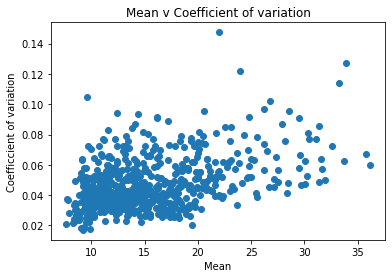

In [28]:
means = df.groupby('series_uid').mean().rename(columns={'ltp': 'series_mean'}).reset_index()
std_deviations = df.groupby('series_uid').std().rename(columns={'ltp': 'series_std_dev'}).reset_index()
comparison_df = pd.merge(means, std_deviations, on='series_uid')
comparison_df['coefficients_of_variation'] = comparison_df['series_std_dev'] / comparison_df['series_mean']

pearson_cor, p_value = stats.pearsonr(comparison_df['series_mean'], comparison_df['coefficients_of_variation'])
print(f"Pearsonr correlation value is: {pearson_cor} with a p_value of {p_value}, indicating that higher mean price values "
      "have higher volitility")
plt.scatter(comparison_df['series_mean'], comparison_df['coefficients_of_variation'])
plt.ylabel('Coefficcient of variation')
plt.xlabel('Mean')
plt.title("Mean v Coefficient of variation")
plt.show()

### Finding the peaks

In [52]:
print(df)
for series_uid in df['series_uid'].unique():
    sub_df = df[df['series_uid'] == series_uid]
    index_of_peak = sub_df['ltp'].idxmax(axis=1)
    print(sub_df)
    print(index_of_peak)

       series_uid   ltp
0            2901  10.0
1            2901  10.0
2            2901  10.0
3            2901  10.5
4            2901   9.8
...           ...   ...
28980        8967  16.0
28981        8967  17.5
28982        8967  17.0
28983        8967  17.0
28984        8967  17.0

[27677 rows x 2 columns]
    series_uid   ltp
0         2901  10.0
1         2901  10.0
2         2901  10.0
3         2901  10.5
4         2901   9.8
..         ...   ...
62        2901  10.0
63        2901  10.5
64        2901  11.0
65        2901  10.0
66        2901  10.0

[67 rows x 2 columns]
9
     series_uid   ltp
67         2910  11.5
259        2910  11.5
260        2910  11.0
261        2910  11.5
262        2910  12.0
263        2910  11.0
264        2910  11.0
265        2910  10.5
266        2910  12.0
267        2910  11.0
268        2910  11.0
269        2910  11.5
270        2910  11.5
271        2910  11.0
272        2910  11.0
273        2910  11.0
274        2910  11.5
275        29

2940        3423  11.0
2577
      series_uid   ltp
2578        3417  18.5
2579        3417  18.0
2580        3417  19.5
2581        3417  19.5
2582        3417  17.5
2583        3417  19.0
2584        3417  18.0
2585        3417  18.5
2586        3417  18.5
2587        3417  18.0
2588        3417  18.5
2589        3417  19.0
2590        3417  18.0
2591        3417  19.0
2592        3417  18.5
2593        3417  18.0
2594        3417  18.5
2595        3417  19.5
2596        3417  18.0
2597        3417  19.5
2598        3417  19.0
2599        3417  19.0
2600        3417  17.5
2601        3417  18.0
2602        3417  18.5
2603        3417  19.0
2604        3417  19.0
2605        3417  18.0
2606        3417  18.0
2607        3417  18.5
2608        3417  17.5
2609        3417  18.5
2610        3417  18.5
2611        3417  18.5
2612        3417  17.5
2613        3417  18.5
2614        3417  19.0
2615        3417  18.0
2580
      series_uid   ltp
2616        3418  11.5
2617        3418   9.0
2

4523
      series_uid   ltp
4550        3986  15.0
4551        3986  14.0
4552        3986  15.0
4553        3986  14.5
4554        3986  14.5
4555        3986  15.0
4556        3986  15.5
4557        3986  16.5
4558        3986  14.0
4559        3986  15.5
4560        3986  15.5
4561        3986  15.5
4562        3986  14.5
4563        3986  15.5
4564        3986  14.5
4565        3986  16.0
4566        3986  14.5
4567        3986  15.0
4568        3986  15.5
4569        3986  15.0
4570        3986  16.0
4571        3986  16.0
4572        3986  14.0
4573        3986  16.0
4574        3986  15.0
4575        3986  16.5
4576        3986  15.0
4577        3986  15.0
4578        3986  15.0
4579        3986  14.5
4580        3986  15.5
4581        3986  15.0
4582        3986  15.0
4583        3986  14.0
4584        3986  15.5
4585        3986  15.5
4586        3986  15.5
4587        3986  14.0
4557
      series_uid   ltp
4588        3987  11.0
4589        3987   9.6
4590        3987   9.8
4

6841        4431  15.0
6814
      series_uid   ltp
6842        4436  30.0
6843        4436  27.0
6844        4436  26.0
6845        4436  25.0
6846        4436  32.0
...          ...   ...
6943        4436  29.0
6944        4436  26.0
6945        4436  30.0
6946        4436  30.0
6947        4436  26.0

[106 rows x 2 columns]
6846
      series_uid   ltp
6948        4437  17.0
6949        4437  16.0
6950        4437  16.0
6951        4437  16.0
6952        4437  16.5
6953        4437  15.5
6954        4437  15.5
6955        4437  16.5
6956        4437  16.0
6957        4437  17.0
6958        4437  16.5
6959        4437  15.5
6960        4437  16.0
6961        4437  16.0
6962        4437  15.5
6948
      series_uid   ltp
6963        4438  12.0
6964        4438  12.0
6965        4438  12.0
6966        4438  11.5
6967        4438  12.5
6968        4438  12.0
6969        4438  12.5
6970        4438  12.5
6971        4438  13.0
6972        4438  11.5
6973        4438  12.5
6974        4438  

      series_uid   ltp
9311        4947  38.0
9404        4947  36.0
9405        4947  29.0
9406        4947  30.0
9407        4947  38.0
...          ...   ...
9470        4947  36.0
9471        4947  30.0
9472        4947  38.0
9473        4947  34.0
9474        4947  34.0

[72 rows x 2 columns]
9420
      series_uid   ltp
9312        4870  13.0
9368        4870  12.5
9369        4870  13.0
9370        4870  12.5
9371        4870  12.5
9372        4870  13.0
9373        4870  13.5
9374        4870  12.5
9375        4870  13.0
9376        4870  13.5
9377        4870  12.5
9378        4870  12.0
9379        4870  12.5
9380        4870  13.0
9381        4870  13.0
9382        4870  12.0
9383        4870  13.0
9384        4870  12.5
9385        4870  12.0
9373
      series_uid  ltp
9319        4865  8.2
9320        4865  8.0
9321        4865  8.4
9322        4865  8.2
9323        4865  8.6
9324        4865  8.2
9325        4865  8.0
9326        4865  8.4
9327        4865  8.4
9328       

[76 rows x 2 columns]
11258
       series_uid   ltp
11318        5377   9.6
11319        5377   9.6
11320        5377   9.8
11321        5377   9.8
11322        5377   9.8
11323        5377  10.0
11324        5377   9.8
11325        5377   9.8
11326        5377  10.5
11327        5377  10.5
11328        5377   9.2
11329        5377   9.6
11330        5377  10.0
11331        5377  10.5
11332        5377   9.8
11333        5377  10.0
11334        5377  10.0
11335        5377  10.5
11326
       series_uid   ltp
11336        5378  14.0
11337        5378  13.5
11338        5378  13.5
11339        5378  14.0
11340        5378  13.5
11341        5378  14.0
11342        5378  12.5
11343        5378  14.0
11344        5378  14.0
11345        5378  14.5
11346        5378  14.5
11347        5378  13.5
11348        5378  14.0
11349        5378  14.5
11350        5378  14.0
11351        5378  13.0
11352        5378  14.0
11353        5378  15.0
11354        5378  13.5
11355        5378  13.5
11353


       series_uid   ltp
13375        5748   9.8
13376        5748  10.0
13377        5748  10.5
13378        5748  11.0
13379        5748  11.0
13380        5748  10.0
13381        5748   9.4
13382        5748  10.0
13383        5748  10.5
13384        5748  10.0
13385        5748   9.8
13386        5748   9.8
13387        5748  10.5
13388        5748  10.0
13389        5748  11.5
13390        5748  10.5
13391        5748  11.5
13392        5748  10.5
13393        5748  10.5
13394        5748   9.6
13395        5748  10.5
13396        5748   9.8
13397        5748  10.5
13398        5748   9.8
13399        5748   9.8
13400        5748   9.6
13401        5748  10.0
13402        5748   9.6
13403        5748  10.0
13404        5748  10.5
13405        5748  11.0
13406        5748  11.0
13407        5748   9.8
13408        5748  10.0
13409        5748  11.0
13410        5748  10.0
13411        5748   9.8
13412        5748  10.0
13413        5748  10.0
13414        5748   9.8
13415        574

       series_uid   ltp
15577        6311  15.5
15578        6311  16.0
15579        6311  15.0
15580        6311  15.5
15581        6311  15.5
15582        6311  16.0
15583        6311  15.0
15584        6311  15.5
15585        6311  16.5
15586        6311  14.0
15587        6311  15.5
15588        6311  16.0
15589        6311  16.0
15590        6311  16.5
15591        6311  15.0
15592        6311  15.0
15593        6311  16.5
15594        6311  16.0
15595        6311  15.5
15596        6311  15.0
15597        6311  15.0
15598        6311  16.5
15599        6311  16.0
15600        6311  15.0
15601        6311  16.5
15602        6311  16.5
15603        6311  16.0
15604        6311  16.0
15605        6311  16.0
15606        6311  16.0
15607        6311  16.0
15608        6311  15.5
15609        6311  15.5
15610        6311  16.0
15611        6311  16.0
15612        6311  15.0
15613        6311  15.5
15614        6311  15.5
15615        6311  15.5
15616        6311  15.5
15617        631

[62 rows x 2 columns]
18071
       series_uid   ltp
18127        6575  19.5
18128        6575  20.0
18129        6575  20.0
18130        6575  21.0
18131        6575  18.0
18132        6575  21.0
18133        6575  19.0
18134        6575  20.0
18135        6575  20.0
18136        6575  19.0
18137        6575  18.5
18138        6575  18.0
18139        6575  20.0
18140        6575  21.0
18141        6575  19.0
18142        6575  20.0
18143        6575  19.0
18144        6575  18.5
18145        6575  19.5
18146        6575  21.0
18147        6575  19.5
18148        6575  18.5
18149        6575  18.5
18150        6575  18.0
18151        6575  21.0
18152        6575  20.0
18153        6575  19.5
18154        6575  20.0
18155        6575  20.0
18156        6575  18.5
18157        6575  18.0
18158        6575  19.5
18159        6575  18.5
18160        6575  18.5
18161        6575  18.0
18162        6575  20.0
18163        6575  19.0
18164        6575  18.0
18165        6575  20.0
18166       

       series_uid   ltp
20379        7179  10.5
20380        7179   9.8
20381        7179   9.6
20382        7179   9.8
20383        7179  10.0
20384        7179  10.0
20385        7179   9.8
20386        7179  10.5
20387        7179   9.8
20388        7179   9.6
20389        7179   9.6
20390        7179   9.6
20391        7179  10.0
20392        7179   9.6
20393        7179   9.8
20394        7179   9.8
20395        7179   9.6
20379
       series_uid   ltp
20396        7180  11.0
20397        7180  12.0
20398        7180   9.4
20399        7180  11.5
20400        7180  12.0
20401        7180  11.5
20402        7180  11.5
20403        7180  11.0
20404        7180  11.5
20405        7180  12.0
20406        7180  14.0
20407        7180  11.5
20408        7180  11.5
20409        7180  12.0
20406
       series_uid   ltp
20410        7181  12.5
20411        7181  12.5
20412        7181  12.0
20413        7181  13.0
20414        7181  11.5
20415        7181  11.5
20416        7181  12.0
2041

       series_uid   ltp
22687        7713  17.0
22688        7713  17.0
22689        7713  17.0
22690        7713  18.0
22691        7713  17.5
22692        7713  17.0
22693        7713  17.5
22694        7713  16.5
22695        7713  18.5
22696        7713  16.0
22697        7713  17.5
22698        7713  17.0
22699        7713  18.5
22700        7713  16.5
22701        7713  17.0
22702        7713  18.0
22703        7713  17.5
22704        7713  16.0
22705        7713  16.5
22706        7713  16.5
22707        7713  16.5
22708        7713  16.0
22709        7713  16.5
22710        7713  17.0
22711        7713  19.0
22712        7713  16.5
22713        7713  18.0
22714        7713  17.5
22715        7713  17.5
22716        7713  17.0
22717        7713  16.0
22718        7713  18.0
22719        7713  17.5
22720        7713  17.0
22721        7713  17.5
22722        7713  18.0
22723        7713  18.5
22724        7713  18.0
22725        7713  17.5
22726        7713  18.0
22727        771

       series_uid   ltp
24851        8385  34.0
24852        8385  30.0
24853        8385  30.0
24854        8385  36.0
24855        8385  32.0
...           ...   ...
24910        8385  32.0
24911        8385  29.0
24912        8385  30.0
24913        8385  40.0
24914        8385  40.0

[64 rows x 2 columns]
24860
       series_uid   ltp
24915        8386  14.0
24916        8386  15.0
24917        8386  14.0
24918        8386  13.5
24919        8386  14.0
24920        8386  14.0
24921        8386  13.5
24922        8386  13.5
24923        8386  14.5
24924        8386  13.0
24925        8386  13.5
24926        8386  14.0
24927        8386  13.5
24928        8386  14.0
24929        8386  13.5
24930        8386  13.5
24931        8386  14.0
24932        8386  13.5
24933        8386  13.5
24934        8386  14.0
24935        8386  13.5
24936        8386  13.5
24937        8386  13.5
24938        8386  14.0
24939        8386  15.5
24940        8386  13.0
24941        8386  13.5
24942      

27005        8789  15.0
26967
       series_uid   ltp
27006        8791  15.5
27007        8791  14.5
27008        8791  15.0
27009        8791  13.0
27010        8791  13.0
...           ...   ...
27119        8791  13.5
27120        8791  14.0
27121        8791  13.0
27122        8791  13.5
27123        8791  15.0

[118 rows x 2 columns]
27006
       series_uid   ltp
27124        8799  23.0
27520        8799  21.0
27521        8799  22.0
27522        8799  20.0
27523        8799  21.0
27524        8799  21.0
27525        8799  21.0
27526        8799  19.5
27527        8799  20.0
27528        8799  21.0
27529        8799  22.0
27530        8799  21.0
27531        8799  19.5
27532        8799  21.0
27533        8799  20.0
27534        8799  22.0
27535        8799  23.0
27536        8799  19.0
27537        8799  20.0
27538        8799  23.0
27539        8799  21.0
27540        8799  22.0
27541        8799  22.0
27542        8799  22.0
27543        8799  22.0
27544        8799  21.0
2754